<br> <img src="https://serea2017.uniandes.edu.co/images/Logo.png" height="80" width="150" align="Center" /> <br>

## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Sistemas de Recomendación de filtrado colaborativo con preferencias implícitas

## Actividad 12


### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres:

    Arturo Guerrero            (201823464)
    Carlos Andres Paez Rojas   (201924257)

En este cuaderno vamos a estudiar los sistemas de recomendación de filtrado colaborativo con preferencias implícitas. Vamos a centrarnos en un método incluido en la biblioteca de Spark, conocido como *Mínimos Cuadrados Alternantes* (ALS). 

## 1. Introducción

Los sistemas de recomendación se han convertido en parte importante de la industria, potenciando el volumen de ventas a partir de recomendaciones personalizadas. Estos sistemas tienen la prioridad de facilitar la toma de decisiones de los usuarios.  Por ejemplo,  si se tienen muchas opciones de donde elegir, se puede esperar que la elección de un solo producto sea más compleja que si se tienen unas pocas opciones. De esta manera, si se ofrecen los productos adecuados, las ventas pueden incrementar de manera significativa.Bien implementados, los sistemas de recomendación pueden brindar ventajas competitivas importantes para las compañías.


Los sistemas de recomendación los podemos ver como motores diseñados para ayudar a los usuarios a encontrar los artículos que les gustan, pero también los podemos pensar como sistemas de información inteligentes que tienen como objetivo ayudar a los usuarios a manejar el problema de la sobrecarga de información. En este sentido, lo que distingue a los sistemas de recomendación de los motores de búsqueda es que aplican el aprendizaje automático de una manera personalizada. Por lo tanto, los sistemas de recomendación permiten construir modelos para satisfacer las preferencias de los usuarios, y encontrar los artículos o servicios necesarios para obtener un mejor sustento y bienestar individual y social.



Veamos algunos ejemplos de sistemas de recomendación en la industria:

- Métodos basados en contenido: el punto más importante para este tipo de sistemas es la extracción de patrones. Por ejemplo, la compañía Pandora, que ofrece musica online por *streaming*, extrajo patrones (*features*) de un conjunto de canciones como parte de Proyecto del Genoma Musical. De esta forma, las canciones se respresentaron por un vector de aproximadamente 450 atributos. Una vez se cuenta con este conjunto de patrones, el problema de recomendación se puede estudiar como uno de clasificación binaria. Entonces se construyen modelos que estimen la probabilidad de que a un usuario le guste una canción específica basado en el conjunto de entrenamiento de su historial de canciones, y se recominedan las K canciones que obtengan una mayor probabilidad. Bajo esta aproximación a los sistemas de recomendación por contenido, es crucial la construcción de un buen conjunto de patrones para su aplicación adecuada y exitosa.


- Filtrado colaborativo: Bajo la perspectiva del filtrado colaborativo, se busca caracterizar la relación entre usuarios e items sin requerir información específica de los usuarios e items, sino solamente utilizando un valor de preferencia *explícito* o *implícito*, expresando la interacción entre usuario e items. 

Un **rating explícito** consiste en un valor numérico, categórico o un *like*, mientras que un **rating implícito** consiste en un *índice* de preferencia, como un *click*, una vista o una compra. Un ejemplo bastante conocido es el de la recomendación de películas como en Netflix. Es común contar con ratings valorados en una escala numérica, donde es fácil ver si el usuario a disfrutado o no de la película. Sin embargo, muchas veces los usuarios no proveen ratings para todas las películas, reduciendo la cantidad de datos disponibles para construir las recomendaciones. Netflix al menos puede identificar si un usuario vió una película, sin saber si le gustó o no, simplemente que la vió. Este último es un rating implícito, y suele ser más común que un rating explícito. De esta manera, es factible que al centrarse en ratings implícitos, la información disponible sea mayor (aunque menos expresiva). 

- Métodos híbridos de filtrado colaborativo e información demográfica: Una red social como Facebook o Linkedin cuenta con bastante información demográfica de los usuarios. Con base en estos datos se pueden identificar usuarios similares a partir de sus características en común. De manera similar al método basado en contenido, se puede construir un vector de patrones para cada usuario y se generan los modelos para predecir la probabilidad de preferir ciertos items.


Para una introducción más amplia a los sistemas de recomendación, pueden estudiar estos videos online: 
1. https://www.youtube.com/watch?v=bLhq63ygoU8&feature=emb_logo

2. https://www.youtube.com/watch?v=mRToFXlNBpQ

## 2. Filtrado colaborativo y preferencias implíctas

Para esta actividad vamos a utilizar el método de mínimos cuadrados alternantes (ALS). Esta técnica busca descomponer una matriz de preferencias $R_{m\times n}$, con $m$ usuarios y $n$ items, en dos matrices más pequeñas: la matriz de usuarios con sus vectores de patrones latentes $U_{m\times k}$ y la respectiva matriz de items $V_{k\times n}$. Se debe tener en cuenta que la matriz $R_{m\times n}$ tiene muchos datos faltantes (una matriz *sparse*), pues muchos usuarios interactuan con unos pocos items.

Entonces, la multiplicación de las matrices $U$ y $V$ permite aproximar la matriz original, y de manera sencilla (pues contaríamos con dos matrices *densas* que incluyen $k$ factores/patrones latentes) podemos construir e interpretar las preferencias estimadas de cada usuario por cada item.

Para estimar $U$ y $V$, resulta conveniente utilizar el método de los ALS. De este modo, se resuelve un vector de patrones a la vez, alternando primero para la matriz de usuarios y luego para la matriz de items, y se puede ejecutar de manera paralela (siguiendo la filosofía de Spark). Por ejemplo, inicializando aleatoriamente $U$, fijándola, y resolviendo para $V$, y luego volver y resolver para $U$ utilizando la solución previa para $V$, y repetir hasta converger. 

Como resultado, el producto punto entre $U$ y $V$ permite estimar $\hat R$, para todos los pares usuario-item, así no haya habido interacción previa entre los pares. Esta metdología fue presentada en el paper: 

*Hu, Y., Koren, Y., Volinsky, Ch. (2008) Collaborative filtering for implicit feedback datasets. Proceedings 2008 Eighth IEEE International Conference on Data Mining, Washington, USA, 3022-3026.*

Veamos a continuación la implementación del método con un conjunto de datos con preferencias implícitas.

## 2.1 Procesamiento de datos

Vamos a utilizar el archivo de datos *Online Retail* (del repositorio de Machine Learning UCI), el cual contiene todas las compras para una compañía de venta al por menor en el Reino Unido durante ocho meses.

Primero carguemos algunas bibliotecas que van a ser útiles para el pre-procesamiento de los datos: 

In [1]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse.linalg import spsolve

import random
import datetime


Carguemos los datos del archivo .xls:

In [2]:
website_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

try:
    retail_data = pd.read_excel(website_url) # No debería tardar mucho
except (http.client.IncompleteRead) as e:
    retail_data = e.partial

Debemos tomar todas las transacciones para cada usuario y preparar los datos para la implementación del ALS. Para ello necesitamos un ID unico por usuario/fila, y un ID unico por item/columna. Los valores de la matriz deben consistir en el número de compras de cada usuario por cada item. 

In [3]:
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


El conjunto de datos incluye un numero identificativo para cada compra, junto con el codigo de stock *StockCode* que nos sirve como ID del tiem. Además contamos con su descripción, el número de ventas, la fecha de la venta, el precio, el ID del usuario, y el pais de origen del usuario.


In [4]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


En el resumen de los datos se puede ver que la mayoría de columnas cuentan con información, pero el ID del usuario falta en bastantes filas. Estas observaciones faltantes hacen inservibles las observaciones para nuestros porpósitos (necesitamos el ID del usuario). 


In [5]:
retail = retail_data.loc[pd.isnull(retail_data.CustomerID) == False]

In [6]:
retail.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


Una vez limpiamos la base de datos de observaciones faltantes, podemos relacionar todas las compras con su cliente/usuario. 

Antes de proceder con la matriz de ratings, construyamos una tabla donde podamos encontrar cada ID de item junto con su descripción. 

In [7]:
items_T = retail[['StockCode', 'Description']].drop_duplicates() # pares item/descripcion
items_T['StockCode'] = items_T.StockCode.astype(str) # caracteres

In [8]:
items_T.head()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


Ahora procesar la base de datos para:

- Agrupar las ventas por codigo de stock e ID del item
- Incluir clientes con un total de compras no negativo, y cambiar las sumas que den cero por uno, lo cual puede suceder si un producto es devuelto. Esto lo hacemos para incluir información sobre cualquier tipo de interacción usuario-item. 
- Construir nuestra matriz de datos tipo *sparse*, que haga uso óptimo de memoria (guarda solamente la ubicación y los valores de los items cuando hay interacción)


In [9]:
# Toma el ID de usuario como Entero y selecciona variables relevantes
retail['CustomerID'] = retail.CustomerID.astype(int) 
retail = retail[['StockCode', 'Quantity', 'CustomerID']] 

# Agrupamos e indicamos si hubo interacción
g_retail = retail.groupby(['CustomerID', 'StockCode']).sum().reset_index() 
g_retail.Quantity.loc[g_retail.Quantity == 0] = 1 

# Nos quedamos con usuarios con compras positivas
g_ventas = g_retail.query('Quantity > 0') 

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
G:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Obtenemos las ventas agrupadas:

In [10]:
g_ventas.head()


,CustomerID,StockCode,Quantity
0,12346,23166,1
1,12347,16008,24
2,12347,17021,36
3,12347,20665,6
4,12347,20719,40


Ahora, en lugar de representar un rating explícito, podemos tomar el número de items adquiridos como una *proxy* de la **confianza** sobre la intensidad de la interacción usuario-item. Es decir, entre más unidades del item se adquieren por parte de un usuario, mayor será el peso para el rating en nuestra matriz de preferencias. 

A continuación creamos la matriz de tipo *sparse*:

In [21]:
from pandas.api.types import CategoricalDtype

In [22]:
usuarios = list(np.sort(g_ventas.CustomerID.unique())) 
items = list(g_ventas.StockCode.unique()) 
confianza = list(g_ventas.Quantity) 
# Construimos la matriz
filas = g_ventas.CustomerID.astype(CategoricalDtype(categories=usuarios)).cat.codes 
cols = g_ventas.StockCode.astype(CategoricalDtype(categories=items)).cat.codes 
prefs_sparse = sparse.csr_matrix((confianza, (filas, cols)), shape=(len(usuarios), len(items)))

Revisemos la matriz que hemos declarado:

In [23]:
prefs_sparse

<4338x3664 sparse matrix of type '<class 'numpy.intc'>'
	with 266723 stored elements in Compressed Sparse Row format>

La matriz tiene 4338 usuarios y 3664 items. De todas las posibles interacciones, se tienen 266723 con alguna compra. 

Esto es:

In [24]:
# Interacciones posibles
mat_dim = prefs_sparse.shape[0]*prefs_sparse.shape[1] 

# Numero de interacciones
num_ventas = len(prefs_sparse.nonzero()[0]) 
sparsity = 100*(1 - (num_ventas/mat_dim))
sparsity

98.32190920694744

El 98.3% de la matriz de interacciones es nula o *sparse*. 

Con el fin de aplicar los algoritmos de filtrado colaborativo, el porcentaje no debería superar un 99.5% aprox. 

## 2.2 Experimentos de aprendizaje 
### Entrenamiento/Prueba vs. Validacion cruzada

Normalmente para problemas de aprendizaje computacional supervisado, debemos probar si el modelo que entrenamos geenraliza de buena manera la muestra de datos utilizada, esto es, si predice de buena manera observaciones nuevas que no pertenecen a la muestra inicial. Esto se suele hacer creando un conjunto de prueba completamente distinto al conjunto de entrenamiento, tomando una muestra aleatoria del conjunto total de observaciones (en nuestro caso una muestra aleatoria de usuarios) y separandola del conjunto de entrenamiento. 

Ahora, bajo el método de filtrado colaborativo esto no funciona del todo porque necesitamos de todas las interacciones usuario-item para encontrar una factorización apropiada de la  matriz de preferencias. Una mejor alternativa consiste en *esconder* aleatoriamente cierta proporción de interacciones del modelo durante la fase de entrenamiento. Luego, se revisa en la fase de validación cuántos items de los que fueron recomendados en verdad terminaron siendo comprados por los usuarios. El desempeño del modelo se puede evaluar a partir de la tasa de aciertos del modelo en validación. De todos modos, también podríamos tomar un punto del tiempo para separar el entrenamiento de la predicción y evaluar el error en predicción. 

En este caso, tenemos un periodo de tiempo corto y es poco probable que los productos que se hayan adquirido una vez vuelvan a ser aduqiridos en tan poco tiempo. Entonces, el conjunto de entrenamiento va a consistir en los datos originales pero omitiendo un porcentaje aleatorio de interacciones, *enmascaradas* como cero. De esta manera se asume para cada iteracción que esos items enmasacardos no han sido adquiridos por el usuario, y probamos si el algoritmo le recomendaría esos productos. En consecuencia, si se puede observar que los usuarios terminaron comprando esos productos recomendados, se puede concluir que el sistema hace bien su trabajo.

También podemos verificar que nuestro sistema mejore una recomendación basada en la popularidad media, como un modelo de referencia (*Baseline*).


A continuación ejecutamos nuestro propio codigo para el ALS. Primero escribimos una función para enmascarar los datos de validación.

In [25]:
def entrena(ratings, pct_val = 0.2):
    '''
    Input: Matriz de ratings
    Output: matriz de entrenamiento CE y de validacion CV, y user_inds
    
    Esta función toma la matriz orginal y enmascara un porcentaje de ratings pata la validacion
    El conjunto de validacion (CV) va a tener todos los ratings originales, mientras que el de entrenamiento (CE)
    reemplaza el porcentaje señalado con ceros
    
    pct_val: porcentaje de iteraciones a enmascarar
    user_inds: lista de usuarios aleatoriamente elegidos y enmascarados en CE.
    '''
    
    random.seed(0) # Semilla aeatoria
    
    CV = ratings.copy() 
    CV[CV != 0] = 1 # CV como una matriz binaria
    
    CE = ratings.copy() 
    non0_inds = CE.nonzero() # Indices donde hay interaccion
    non0_pares = list(zip(non0_inds[0], non0_inds[1])) # lista de indices usuario-item con interaccion
    
    num_muestra = int(np.ceil(pct_val*len(non0_pares))) 
    muestra = random.sample(non0_pares, num_muestra) # sub-muestreo sin reemplazo
    
    user_inds = [index[0] for index in muestra] # indices de usuario
    item_inds = [index[1] for index in muestra] # inidices de items
    
    CE[user_inds, item_inds] = 0 # Asigna 0 sobre las observaciones elegidas
    CE.eliminate_zeros() # Elimina los ceros en el arreglo sparce
    return CE, CV, list(set(user_inds)) 


Con la funcion anterior tenemos nuestro conjunto de entrenamiento, un conjunto de validacion  binario (compra/no compra) y una lista de los usuarios dejados por fuera del entrenamiento para validacion. Entonces, si enmascaramos el 20% de los usuarios, evaluaremos el desempeño del modelo sobre estos usuarios.

In [26]:
CE, CV, users_V = entrena(prefs_sparse, pct_val = 0.2)

## 2.3 Método de Mínimos Cuadrados Alternantes (ALS)
Ahora podemos implementar el ALS sobre nuestros ratings implícitos (siguiendo el paper de  Hu et al. 2008).

En primera instancia, debemos transformar la matriz de preferencias en una matriz de confianza:

$$
C_{ui}=1+\alpha r_{ui}
$$

donde $C_{ui}$ representa la confianza del usuario $u$ sobre el item $i$ y $\alpha$ representa un factor de incremento lineal con respecto al rating del usuario.


Enfocándonos en el modelo de factores ($f$) latentes, le asignamos a cada usuario un vector $x_u \in \mathbb{R}^f$ y a cada item un vector $y_i\in \mathbb{R}^f$, donde la prediccion corresponde con el producto interno $$ \hat p_{ui} = x^T_u y_i. $$
Recordemos que esta predicción es binaria.

En este caso vamos a incorporar el parámetro de confianza sobre la minimización de la función obejtivo:
$$
\min_{x,y} \sum_{u,i} c_{ui}(p_{ui} - x^T_u y_i)^2 + \lambda\bigl( \sum_u ||x_u||^2 + \sum_i ||y_i ||^2 \bigr) \tag{1}
$$

La clave para resolver este problema mediante ALS consiste en que al fijar los factores de usuario o los de item, la función de coste se vuelve cuadrática. Al diferenciar $(1)$ podemos minimizar la función para los usuarios:
$$
x_u=(Y^TC_uY+\lambda I)^{−1}Y^TC_up(u)
$$
y de manera similar para los items,
$$
y_i=(X^TC_iX+\lambda I)^{−1}X^TC_yp(i)
$$


In [27]:
def implicit_con_ALS(CE, lambda_val = 0.1, alpha = 40, itera = 10, factores = 20, semilla = 0):
    '''
    Input:
    CE: conjunto de entrenamiento con m usuarios y n items. Matriz sparse csr
    lambda_val: parametro de regularizacion ALS. 
    alpha: Parametro de confianza para el rating implicito 
    itera: numero de iteraciones para el ALS. Un  mayor numero permite una mejor convergencia
    factores: el numero de factores latentes. Incrementar su numero aumenta el riesgo de sobre-ajuste 
    semilla: semilla aleatoria para reproducibilidad
    Output:
    El vector de factores o patrones para usuarios y para items.
    '''
    
    # declaramos la matriz de confianza
    
    conf = (alpha*CE) 
    
    num_user = conf.shape[0]
    num_item = conf.shape[1] 
    
    # Incializacion aleatoria de los vectores de usuario e item
    random = np.random.RandomState(semilla)
    X = sparse.csr_matrix(random.normal(size = (num_user, factores))) 
    Y = sparse.csr_matrix(random.normal(size = (num_item, factores))) 
    
    X_eye = sparse.eye(num_user)
    Y_eye = sparse.eye(num_item)
    lambda_eye = lambda_val * sparse.eye(factores) # termino de regularizacion lambda*I. 
    
    # Bucle ALS
   
    for iter_step in range(itera): # Itera alternando entre X e Y
        # Calculamos yTy, xTx al principio de cada iteracion para optimizar el coste computacional
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)
        # Fijamos Y
        for u in range(num_user):
            conf_samp = conf[u,:].toarray() # convierte a un vector denso la fila del usuario (de la matriz de confianza)
            pref = conf_samp.copy() 
            pref[pref != 0] = 1 # Vector de preferencia binario
            CuI = sparse.diags(conf_samp, [0]) # Término Cu-I 
            yTCuIY = Y.T.dot(CuI).dot(Y) # Termino yT(Cu-I)Y  
            yTCupu = Y.T.dot(CuI + Y_eye).dot(pref.T) # Término yTCuPu
            X[u] = spsolve(yTy + yTCuIY + lambda_eye, yTCupu) 
            # Resuelve para Xu = ((yTy + yT(Cu-I)Y + lambda*I)^-1)yTCuPu, Ecuacion 4 del paper 
        
        # Fijamos X
        for i in range(num_item):
            conf_samp = conf[:,i].T.toarray() # Se transpone y se convierte a matriz densa
            pref = conf_samp.copy()
            pref[pref != 0] = 1 # Crea la matriz binaria
            CiI = sparse.diags(conf_samp, [0]) # Calcula el termino Cu-I 
            xTCiIX = X.T.dot(CiI).dot(X) # Se calcula el termino xT(Cu-I)X 
            xTCiPi = X.T.dot(CiI + X_eye).dot(pref.T) # Se calcula el temrino xTCiPi 
            Y[i] = spsolve(xTx + xTCiIX + lambda_eye, xTCiPi) 
            # Resuelve para Yi = ((xTx + xT(Cu-I)X) + lambda*I)^-1)xTCiPi
    
    return X, Y.T 


Intentemos diez iteraciones para verificar que el codigo funciona, tomando 20 factores latentes junto con un coefiencte de confianza de 15 y una regularización de 0.1. 

In [28]:
tiempo0 = datetime.datetime.now()
print('\nInicia nuestro ALS: ', tiempo0)

user_vecs, item_vecs = implicit_con_ALS(CE, lambda_val = 0.1, alpha = 15, itera = 10, factores = 20)

print('Tiempo en completarse las 10 iteraciones: ', datetime.datetime.now()-tiempo0)


Inicia nuestro ALS:  2020-11-15 00:49:47.407781
Tiempo en completarse las 10 iteraciones:  0:06:13.605147


Podemos ver los ratings para un usuario dado tomando el producto punto entre los vectores de usuario e item (U y V):  

In [29]:
user_vecs[0,:].dot(item_vecs).toarray()[0,:5]

array([ 0.12088319,  0.02528647,  0.01163801,  0.01294093, -0.02575397])

Estos son los valores de preferencia estimados para el primer usuario sobre los primeros 5 items, de un total de 3664 en stock. 

### Pregunta
Cuál es el item con una mayor preferencia sobre todo el stock de productos?


In [109]:
item = pd.DataFrame(user_vecs[:,:].dot(item_vecs).toarray())
item = pd.DataFrame(item.mean())
item.rename(columns={0:"Mean"}, inplace=True)
item = item.sort_values(by=['Mean'], ascending = False)
item.head(1)

,Mean
396,0.669602


> El item 396 es el de mayor preferencia, con valor estimado promedio de 0.66

## 3. Implicit: Implementacion óptima del ALS

Hasta ahora no hemos indagando en la convergencia del modelo, lo cual puede tomar más tiempo, y por eso mismo, es recomendable hacer uso de un código optimizado. 

Hasta el momento hacemos uso de bastantes bucles y no tomamos ventaja del hecho de que el algoritmo es paralelizable, pues cada iteración se puede realizar sobre los vectores de item o de usuario de manera independiente. Para ello podemos hacer uso de la versión de ALS para Python (utilizando Cython) que paraleliza el codigo entre distintos procesadores. Antes tenemos que instalar la bilbioteca `implicit`. 

Para mayores detalles, puede investigar: https://pypi.org/project/implicit/

Para instalarlo desde el prompt de Anaconda (https://anaconda.org/conda-forge/implicit):

`conda install -c conda-forge implicit` 

También debemos chequear que la version de `scipy` sea 0.16 o posterior.

In [112]:
import scipy
scipy.__version__

'1.4.1'

In [113]:
import implicit

En esta versión no se hace uso explícito del parametro $\alpha$ que utilizamos para ponderar la confianza de los ratings. Este paso lo debemos hacer nosotros antes de introudcir el input. También necesitamos declarar el tipo de la matriz como *double* para ejecutar la función de ALS.

In [114]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((CE*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                          iterations = 50)


This method is deprecated. Please use the AlternatingLeastSquares class instead


Con esta implementación de `implicit` conseguimos unas mejores predicciones tras utilizar un mayor número de iteraciones y conseguir una mejor convergencia del modelo. Pero ahora vemos cómo medimos el desempeño del modelo.


## 4. Evaluación del sistema de recomendación

Recordemos que nuestro conjunto de entrenamiento había dejado por fuera el 20% de las observaciones con ventas. Ahora vamos a evaluar el desempeño del modelo sobre este 20%. Específicamente debemos contrastar si las recomendaciones obtenidas por nuestro sistema cazan con los items que los usuarios temrinaron comprando. 

Una métrica muy usual es el Area bajo la Curva ROC (Receiver Operating Characteristic), o AUC. Una mayor area significa que los items recomendados en las posiciones altas de la lista de recomendación terminan siendo comprados por los usuarios. En esta parte implementaremos el AUC para evaluar la calidad del ranking de nuestras recomendaciones.

El AUC se consigue al graficar la tasa de verdaderos positivos (TPR) contra la tasa de falsos positivos (FPR) para todos los umbrales de decisión, dadas por:
\begin{equation}
\label{tpr}
TPR=\frac{TP}{TP+FN}  
\end{equation}	  
\begin{equation}
\label{fpr}
FPR=\frac{FP}{FP+TN}  
\end{equation}


Para ello implementamos una función que calcule el AUC para cualquier usuario que tenga al menos un item en el conjunto de validación. Como benchmark de comparación tomamos el AUC que se hubiera obtenido si se recomendaran los items más populares. Con este fin, utilizamos la biblioteca Scikit-learn para calcular las tasas TPR y FPR.

In [115]:
from sklearn import metrics

In [116]:
def auc_score(preds, prueba):
    '''
    Esta funcion obtiene el AUC. 
    Input:
    parameters:
    preds: las predicciones del sistema
    prueba: las ventas verdaderas
    Output:
    AUC
    '''
    
    fpr, tpr, umbrales = metrics.roc_curve(prueba, preds)
    return metrics.auc(fpr, tpr)   

In [117]:
np.concatenate((np.zeros(67),np.ones(12)))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [118]:
prueba=np.concatenate((np.zeros(54),np.ones(25)))
preds=np.concatenate((np.zeros(67),np.ones(12)))
fpr, tpr, umbrales = metrics.roc_curve(prueba, preds)
metrics.auc(fpr, tpr)

0.74

Ahora utilizamos esta función para calcular el AUC para cada usuario e el conjunto de validación (que coinciden con las observaciones enmascaradas del conjunto de entrenamiento). También calculamos el AUC para los items más populares.

In [119]:
def AUC_val(CE, users_V, preds, CV):
    '''
    Esta funcion calcula el AUC medio por usuario para todo usuario en el conjunto de validacion
    Input:
    CE: Conjunto de entrnamiento con un porcentaje de las interacciones originales enamscaradas
    preds: la matriz con las predicciones de los ratings para cada par usuario-item (lista
    con vectores de usuario y vectores de items)
    users_V: indices de los usuarios de validacion
    CV: conjunto de validacion 
    Output:
    AUC medio del CV para las interacciones usuario-item y para los items más populares
    '''
    
    # Inicializamos la lista para guardar el AUC de validacion 
    rec_auc = [] 
    # y el AUC para la recomendación por popularidad
    pop_auc = [] 
    
    # Tomamos la suma de interacciones por item para encontrar lo más popular
    pop_items = np.array(CV.sum(axis = 0)).reshape(-1) 
    item_vecs = preds[1]
    
    for user in users_V: 
        user_i = CE[user,:].toarray().reshape(-1) # usuario de validacion
        user_val = np.where(user_i == 0) # 
        
        # Toma la prediccion para el usuario-item
        user_vec = preds[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,user_val].reshape(-1)
        
        # Selecciona los ratings estimados para el usuario 
        actual = CV[user,:].toarray()[0,user_val].reshape(-1) 
        
        # Toma los pares con interacciones binarias de los datos originales
        pop = pop_items[user_val] # Popularidad del item
        rec_auc.append(auc_score(pred, actual)) # Calcula y guarda el AUC para el ususario
        pop_auc.append(auc_score(pop, actual)) # Calcula el AUC por popularidad

    
    return float('%.3f'%np.mean(rec_auc)), float('%.3f'%np.mean(pop_auc))  
   # Devuelve el AUC medio para validacion y por popularidad


Ahora podemos usar la funcion para evaluar el desempeño de nuestro sistema. Para ello, debemos tomar la salida de nuestra funcion ALS y pasarla a formato de csr_matrix, y trasponer los vectores de items. 

In [120]:
AUC_val(CE, users_V, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], CV)

(0.87, 0.814)

Podemos ver que nuestro sistema de recomendación es al menos mejor que la recomendación basada en popularidad, con un AUC de 0.87 frente a uno de 0.814. 

### Ejercicio práctico
Revise su algoritmo e intente optimizar los hiper-parámetros para mejorar el valor del AUC. Puede intentar himplementar validación cruzada además de la prueba para controlar el riesgo de sobre-ajuste.


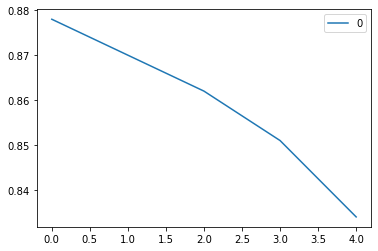

In [164]:
alpha = 15
auc_val = []
for i in range(1, 6):
    CE, CV, users_V = entrena(prefs_sparse, pct_val = i * 0.1)
    user_vecs, item_vecs = implicit.alternating_least_squares((CE*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                          iterations = 50)
    pru = AUC_val(CE, users_V, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], CV)
    auc_val.append(pru[0])
auc_val1 = pd.DataFrame(auc_val)
auc_val1.plot();

### Ejercicio final

Pensemos que si bien el sistema no recomienda items que ya han sido comprados, sí puede estar recomendando otra vez el mismo tipo de productos. Por ejemplo, si un usuario compra una lavadora, ¿tiene sentido recomendarle otra lavadora?

Hay ciertos productos que se compran solo una vez, y requieren más bien de otros productos complementarios que combinen bien con su uso.

Piense en una estrategia para desarrollar un sistema de recomendación que no caiga en la trampa de recomendar productos sustitutos, es decir, productos que cumplan exactamente las mismas funciones que lo que ya han sido adquiridos.

Proponga un algoritmo que tome en cuenta la *diversidad* de las recomendaciones.


## Comentarios finales

Hemos visto cómo diseñar y evaluar un sistema de recomendación con ratings implícitos. En implementaciones de la vida real, si el tamaño de la matriz de ratings es muy grande, puede ser más práctica su implementación en Spark:
https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html

También se pueden seguir explorando los sistemas de recomendación híbridos, incorporando información propia de los usuarios e items además de su comportamiento de compras. La librería de Python `LightFM` de Maciej Kula permite implementar distintos algoritmos con preferencias implícitas y explícitas:
https://making.lyst.com/lightfm/docs/home.html



Para los sistemas de recomendación con ratings explícitos podemos usar `SurPRISE`, que estudiaremos las próximas sesiones, o también pueden explorar este blog:

*Explicit Matrix Factorization: ALS, SGD, and All That Jazz*, por Ethan Rosenthal
    https://www.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/


Finalmente, si buscan datos para la implementación de sistemas de recomendación, pueden explorar el siguiente link: https://gist.github.com/entaroadun/1653794
